# Libraries

In [96]:
import math
import random
from collections import defaultdict, Counter, deque
from typing import Tuple, List, Set, Dict, Counter
from typing import Any, Sequence, Mapping, Iterable, Iterator
from itertools import product, chain, islice
import doctest
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import colorama
from colorama import Fore
import numpy as np
import pylab 
import scipy.stats as stats
from scipy.stats import shapiro 
from scipy.stats import lognorm
from sklearn import linear_model
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
from scipy.stats import truncnorm


In [54]:
#change this for different models 

maxelogain = 32
number_players =  10000 #must be even
games= 1000
monte_n = 20

# Define functions:

In [67]:
#General functions:

class Player:
    """A player with real skill and obvservable elo.
    
    >>> Player('p1', '', '1000')  # test robustness
    Traceback (most recent call last):
        ...
    AssertionError: Must not be empty
    >>> playerA = Player('p1',1001, 1000)
    >>> playerA  # also tests __repr__()
    Player(1001, 1000)
    >>> playerA.update(10)
    >>> print(playerA)  # also tests __str__()
    (1001,1010)
    """
    def __init__(self,name:str, skill: int, elo:int) -> None:
        """Create player with given state.
        """
        #assert name and skill and elo, "Must not be empty"   (If skill is 0, this breaks, will disable this for now)
        self.skill: int = skill
        self.elo: int = elo
        self.name: str = name
            
    def __repr__(self) -> str:
        """Return machine-processable string representation of current state.
        """
        return f"Player({self.name},{str(self.skill)}, {str(self.elo)})"
    
    def __str__(self) -> str:
        """Return human-readable string representation of current state.
        """
        return f"({self.name},{self.skill},{self.elo})"
    
    def update(self, gain : int) -> None:
        """ Update the elo after a match"""
        self.elo = self.elo + gain
        
def match_chess(player1 : Player, player2: Player)->None:
    'a match of chess, using the skill in the expected win chance formula to get the "real" chance of winning'
    P1win = 1/(1+10**((player2.skill - player1.skill)/400))
    P1expec = 1/(1+10**((player2.elo - player1.elo)/400))
    res = random.random()
    
    if res <= P1win:
        player1.update( int(maxelogain*(1-P1expec)) ) 
        player2.update( int(maxelogain*(-1+P1expec) ))
    elif res > P1win:
        player1.update( int(maxelogain*(-P1expec) ) )
        player2.update( int(maxelogain*(P1expec )))

def ranked_elo(players2:List[Player]):
    'input a kist of players (important). Output a ranked list of players. '
    players=players2.copy()
    players.sort(key= lambda x: x.elo)
    players.reverse()
    return players

def ranked_skill(players2:List[Player]):
    'same as above, but this is skill. Outputs a list of lists'
    'Every element is a rank, if multiple player have the same skill, they are in the same rank (i.e same list-element)'
    players=players2.copy()
    players.sort(key= lambda x: x.skill)
    players.reverse()
    ranks = []
    current=[]
    for p in players:
        if (len(ranks)==0 and len(current)==0):
            current += [p]
        else:
            if p.skill == current[0].skill:
                current += [p]
            else:
                ranks += [current]
                current = [p]
    if len(current)!=0:
        ranks += [current]
    return ranks


#Functions for random matchmaking
def chess_round_rand(players:List[Player]) -> None:
    random.shuffle(players)
    order = players
    for i in range(len(players))[::2]:
        match_chess(order[i], order[i+1])
        
def state(players:List[Player]):
    'records the state of a player at this point in the game, I dont think we need this anymore, but I will leave it just in case'
    players2 = players.copy()
    state= [[i.name,i.skill, i.elo] for i in players2]
    return state

def chess_game_rand(players:List[Player], games : int) -> List[List[Player]]:
    'Full simulation'
    global Match_history 
    Match_history = [i for i in range(games+1)]
    
    for i in range(games):
        Match_history[i] = state(players)
        chess_round_rand(players)
    Match_history[-1] = state(players)
    return Match_history

def player_hist(player: str, match_hist):
    'Each players history'
    elos = []
    for state in match_hist:
        for p in state:
            if p[0] == player:  
                elos += [p[2]]
    return elos

def position_score(players:List[Player]):
    r_skill=ranked_skill(players)
    r_elo=ranked_elo(players)
    lenskill=len(ranked_skill(players))
    
    indxplayer = 0
    r_elo_mch = []
    for r in range(lenskill):
        curr=[]
        for i in range(len(r_skill[r])):
            curr += [r_elo[indxplayer]]
            indxplayer += 1
        r_elo_mch += [curr]
    r_elo = r_elo_mch
    score = 0
    for i in range(lenskill):
        if r_skill[i] == r_elo[i]: 
            #print(Fore.GREEN + str(i+1)+'::',  str([p.name for p in r_skill[i]])+' vs ',   str([p.name for p in r_elo[i]]))
            score += len(r_skill[i])
        elif r_skill[i] != r_elo[i]:
            score += 0
            #print(Fore.RED + str(i+1)+'::',  str([p.name for p in r_skill[i]]) +' vs ',   str([p.name for p in r_elo[i]]))
    return score

# Random matchmaking

In [5]:
player_names = ['p'+str(i) for i in range(1,number_players+1)]
player_skills = [ random.randint(1,2800) for i in range(1,number_players+1)]

players = [Player(player_names[i],  player_skills[i], 1000) for i in range(number_players)]

In [ ]:
#The graph of how each player's elo developed over the 100 games
chess_game_rand(players, games) 

'''
x = range(games+1)     #+5
all_the_ys = [player_hist('p'+str(i),Match_history) for i in range(1,number_players+1)]
figure(figsize=(16, 6), dpi=80)

for i in range(len(all_the_ys)):   
    plt.plot(x, all_the_ys[i], label = "Player "+str(i+1))    #+5*[all_the_ys[i][-1]
    

plt.xlabel('Game n') 
plt.ylabel('Elo') 
plt.title("How each player's elo developed over this simulation")
plt.savefig('single_rand_elosgraph.png')
plt.show()
'''

In [ ]:
#How does the elo ranking compare to the real skill ranking?
#position_score(players)

### Distribution:

In [ ]:
#Question: How do our players get distributed?
distr_rand =np.array([int(i[2]) for i in Match_history[-1]])
bins=math.ceil(math.sqrt((max(distr_rand)-min(distr_rand))))
plt.hist(distr_rand ,bins=[i for i in range(min(distr_rand),max(distr_rand))][::bins])
plt.title("Distribution of elos of 100.000 players after 1.000 games")
plt.xlabel('Elo') 
plt.ylabel('Frequency')
plt.savefig('distr_rand2.png')

### Linear regression to find d:

In [43]:
#this is to get data for the Linear regression.
'''
maxelogain = 32
number_players =  10 #must be even
games= 10
nn = 10

df = pd.DataFrame({'diff':[],'games':[] , 'players':[] })

for ppl in (10, 20, 30, 40, 50, 100, 150):
    number_players = ppl
    for g in (10, 20, 30, 40, 50, 100, 150):
        games= g
        for i in range(nn):
            player_names = ['p'+str(i) for i in range(1,number_players+1)]
            player_skills = [ random.randint(1,2800) for i in range(1,number_players+1)]
            players = [Player(player_names[i],  player_skills[i], 1000) for i in range(number_players)]

            chess_game_rand(players, games)
            a =np.array([int(i[2]) for i in Match_history[-1]])
            diff = (max(a)-min(a))/2
            df = df.append( {'diff':diff,'games':games , 'players':number_players }   ,  ignore_index=True)
'''

In [44]:
#df.to_pickle("coefficients1.pkl")

In [ ]:
#df = pd.read_pickle("coefficients1.pkl")

In [ ]:
#The 3D visualization has to be done in another Notebook, because it uses a library that messes up all the other pictures

In [45]:
df = df[['diff', 'games']]
df['diff2'] = [i**2 for i in df['diff'].values.tolist()]

In [46]:
x = df[['diff','diff2']]
y = df['games']

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 4.5361767234602155
Coefficients: 
 [-0.02094857  0.00044641]


In [ ]:
plt.scatter(y, x['diff'],color='g') 

axs = [i for i in range(700)]
fx = []
for i in range(len(axs)):
    fx.append(regr.intercept_ + regr.coef_[0]*axs[i]+regr.coef_[1]*(axs[i]**2) )
plt.plot(fx, axs)

plt.title("Linear regression for d")
plt.xlabel('d') 
plt.ylabel('Game number')
#plt.savefig('Quadratic regression for d')
plt.show()

### Plot 'do until' but using the distribution:

In [68]:
#new functions:
#numpy.random.normal(1000, 913)

def match_chess_img(player1 : Player, player2: Player)->None:
    P1win = 1/(1+10**((player2.skill - player1.skill)/400))
    P1expec = 1/(1+10**((player2.elo - player1.elo)/400))
    res = random.random()
    
    if res <= P1win:
        player1.update( int(maxelogain*(1-P1expec)) ) 
    elif res > P1win:
        player1.update( int(maxelogain*(-P1expec) ) )

def chess_round_rand_img(players:List[Player]) -> None:
    for i in range(len(players)):
        num = random.randint(-846,2846)
        #print('num:' + str(num))
        match_chess_img(players[i], Player('P_img',num, num))
        

In [69]:
#Initialize stuff
df_rand = pd.DataFrame({"nº players":[], "games until ordered":[]})

In [70]:
#graph for random
max_players = 20
for n_players in range(1,max_players):
    n_players = n_players*2 #make number even
    
    for i in range(50): #we will do this a bunch of times for every number of players
        print(n_players, i)
        player_names = ['p'+str(i) for i in range(1,n_players+1)] #create the players
        player_skills = [ random.randint(1,2800) for i in range(1,n_players+1)]
        players = [Player(player_names[i],  player_skills[i], 1000) for i in range(n_players)]
        
        chess_round_rand_img(players)
        games_req = 1
        while position_score(players) != n_players: #check if players are ordered already
            chess_round_rand(players)
            games_req += 1
            if games_req>2000000:
                print(players)
                break
        df_rand = df_rand.append({'nº players':n_players, 'games until ordered':games_req},  ignore_index=True)

2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4 28
4 29
4 30
4 31
4 32
4 33
4 34
4 35
4 36
4 37
4 38
4 39
4 40
4 41
4 42
4 43
4 44
4 45
4 46
4 47
4 48
4 49
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
6 20
6 21
6 22
6 23
6 24
6 25
6 26
6 27
6 28
6 29
6 30
6 31
6 32
6 33
6 34
6 35
6 36
6 37
6 38
6 39
6 40
6 41
6 42
6 43
6 44
6 45
6 46
6 47
6 48
6 49
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
8 16
8 17
8 18
8 19
8 20
8 21
8 22
8 23
8 24
8 25
8 26
8 27
8 28
8 29
8 30
8 31
8 32
8 33
8 34
8 35
8 36
8 37
8 38
8 39
8 40
8 41
8 42
8 43
8 44
8 45
8 46
8 47
8 48
8 49
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7


KeyboardInterrupt: 

In [91]:
df_rand2 = df_rand.copy()
#df_rand2 = df_rand[df_rand['nº players']<30]

C:\Users\giuli\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


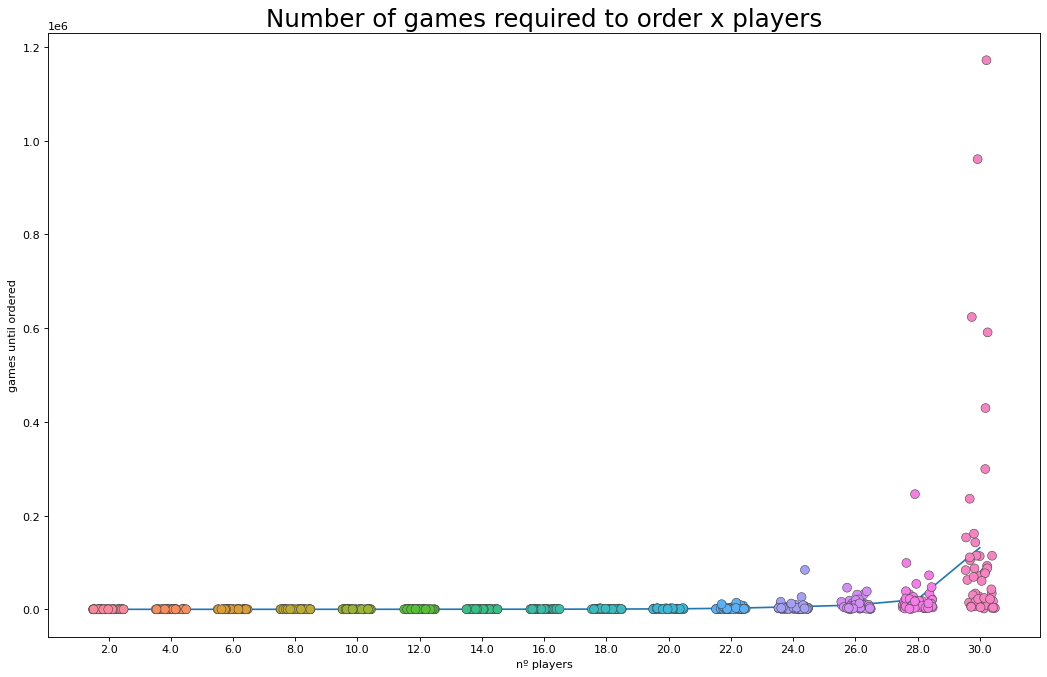

In [134]:
# Draw Stripplot

fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
sns.stripplot(df_rand2['nº players'], df_rand2['games until ordered'], jitter=0.25, size=8, ax=ax, linewidth=.5)
df_rand2.groupby('nº players')['games until ordered'].mean().reset_index()['games until ordered'].plot()

# Decorations
plt.title('Number of games required to order x players', fontsize=22)
#fig.savefig('Avg times to order rand img mean')
plt.show()

# Elo Matchmaking

### New functions:

In [ ]:
#more functions for elo matchmaking
def elo_matchmaking(players:List[Player]) -> List[Player]:
    'orders players based on current elo scores'
    players.sort(key= lambda x: x.elo)
    return players

def chess_round_elo(players:List[Player]) -> None:
    'same as chess_round_rand'
    order = elo_matchmaking(players)
    for i in range(len(players))[::2]:
        match_chess(order[i], order[i+1])    
        
def chess_game_elo(players:List[Player], games : int) -> List[List[Player]]:
    'full simmulation'
    global Match_history2 
    Match_history2 = [i for i in range(games+1)]
    for i in range(games):
        Match_history2[i] = state(players)
        chess_round_elo(players)
    Match_history2[-1] = state(players)
    return Match_history2

In [33]:
player_names2 = ['p'+str(i) for i in range(1,number_players+1)]
player_skills2 = [ random.randint(1,2800) for i in range(1,number_players+1)]

players2 = [Player(player_names2[i],  player_skills2[i], 1000) for i in range(number_players)]

In [34]:
#The graph of how each player's elo developed over the 100 games
chess_game_elo(players2, games) 
'''
x = range(games+1)     #+5
all_the_ys_2 = [player_hist('p'+str(i),Match_history2) for i in range(1,number_players+1)]
figure(figsize=(16, 6), dpi=80)

for i in range(len(all_the_ys_2)):   
    plt.plot(x, all_the_ys_2[i], label = "Player "+str(i+1))  
    

plt.xlabel('Game n') 
plt.ylabel('Elo') 
plt.title("How each player's elo developed over this simulation")
plt.savefig('single_rand_elosgraph.png')
plt.show()
'''

'\nx = range(games+1)     #+5\nall_the_ys_2 = [player_hist(\'p\'+str(i),Match_history2) for i in range(1,number_players+1)]\nfigure(figsize=(16, 6), dpi=80)\n\nfor i in range(len(all_the_ys_2)):   \n    plt.plot(x, all_the_ys_2[i], label = "Player "+str(i+1))  \n    \n\nplt.xlabel(\'Game n\') \nplt.ylabel(\'Elo\') \nplt.title("How each player\'s elo developed over this simulation")\nplt.savefig(\'single_rand_elosgraph.png\')\nplt.show()\n'

In [ ]:
#How does the elo ranking compare to the real skill ranking?
position_score(players2)

### Distribution:

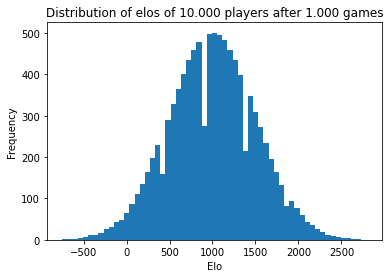

In [35]:
#Question: How do our players get distributed?
distr_elo =np.array([int(i[2]) for i in Match_history2[-1]])
bins=math.ceil(math.sqrt((max(distr_elo)-min(distr_elo))))
plt.hist(distr_elo ,bins=[i for i in range(min(distr_elo),max(distr_elo))][::bins])
plt.title("Distribution of elos of 10.000 players after 1.000 games")
plt.xlabel('Elo') 
plt.ylabel('Frequency')
plt.savefig('distr_elo2.png')

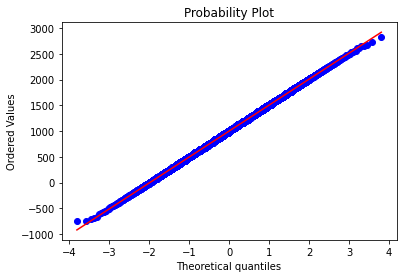

ShapiroResult(statistic=0.9997258186340332, pvalue=0.20236018300056458)

In [39]:
#Is this dist. normal?
stats.probplot(distr_elo, dist="norm", plot=pylab)
#plt.savefig('qq-plot_normal_400p.png')
plt.savefig('qq-plot_normal.png')
pylab.show()
shapiro(distr_elo)


### Linear regression:

In [ ]:
#this is to get data for the Linear regression, commented out because it takes a whiiiiiiile.
'''
#this is to get data for the Linear regression, commented out because it takes a whiiiiiiile.

maxelogain = 32
number_players =  10 #must be even
games= 10
nn = 10

df2 = pd.DataFrame({'diff':[],'games':[] , 'players':[] })

for ppl in (10, 20, 30, 40, 50, 100, 150):
    number_players = ppl
    for g in (10, 20, 30, 40, 50, 100, 150):
        games= g
        for i in range(nn):
            player_names = ['p'+str(i) for i in range(1,number_players+1)]
            player_skills = [ random.randint(1,2800) for i in range(1,number_players+1)]
            players = [Player(player_names[i],  player_skills[i], 1000) for i in range(number_players)]

            chess_game_elo(players, games)
            a =np.array([int(i[2]) for i in Match_history[-1]])
            diff = (max(a)-min(a))/2
            df = df.append( {'diff':diff,'games':games , 'players':number_players }   ,  ignore_index=True)


'''

In [ ]:
#df2.to_pickle("coefficients2.pkl")

In [ ]:
#df2 = pd.read_pickle("coefficients2.pkl")

In [ ]:
df2 = df2[['diff', 'games']]
df2['diff2'] = [i**2 for i in df2['diff'].values.tolist()]
x = df2[['diff','diff2']]
y = df2['games']

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

In [ ]:
plt.scatter(y, x['diff'],color='g') 

axs = [i for i in range(700)]
fx = []
for i in range(len(axs)):
    fx.append(regr.intercept_ + regr.coef_[0]*axs[i]+regr.coef_[1]*(axs[i]**2) )
plt.plot(fx, axs)

plt.title("Linear regression for d")
plt.xlabel('d') 
plt.ylabel('Game number')
#plt.savefig('Quadratic regression for d')
plt.show()

### Plot 'do until' but using the distribution:

In [123]:
#new functions:
#numpy.random.normal(1000, 913)

def match_chess_img(player1 : Player, player2: Player)->None:
    P1win = 1/(1+10**((player2.skill - player1.skill)/400))
    P1expec = 1/(1+10**((player2.elo - player1.elo)/400))
    res = random.random()
    
    if res <= P1win:
        player1.update( int(maxelogain*(1-P1expec)) ) 
    elif res > P1win:
        player1.update( int(maxelogain*(-P1expec) ) )

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)        
        
def chess_round_elo_img(players:List[Player]) -> None:
    for i in range(len(players)):
        elo = players[i].skill
        num = get_truncated_normal(mean=1000, sd=913, low=elo-50, upp=elo+50).rvs()
        match_chess_img(players[i], Player('P_img',num, num))
        


In [135]:
#Initialize stuff
df_elo = pd.DataFrame({"nº players":[], "games until ordered":[]})

In [136]:
#graph for random
max_players = 16
for n_players in range(1,max_players):
    n_players = n_players*2 #make number even
    
    for i in range(50): #we will do this a bunch of times for every number of players
        print(n_players, i)
        player_names = ['p'+str(i) for i in range(1,n_players+1)] #create the players
        player_skills = [ random.randint(1,2800) for i in range(1,n_players+1)]
        players = [Player(player_names[i],  player_skills[i], 1000) for i in range(n_players)]
        
        chess_round_elo_img(players)
        games_req = 1
        while position_score(players) != n_players: #check if players are ordered already
            chess_round_elo(players)
            games_req += 1
            if games_req>2000000:
                print(players)
                break
        df_elo = df_elo.append({'nº players':n_players, 'games until ordered':games_req},  ignore_index=True)

2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4 28
4 29
4 30
4 31
4 32
4 33
4 34
4 35
4 36
4 37
4 38
4 39
4 40
4 41
4 42
4 43
4 44
4 45
4 46
4 47
4 48
4 49
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
6 20
6 21
6 22
6 23
6 24
6 25
6 26
6 27
6 28
6 29
6 30
6 31
6 32
6 33
6 34
6 35
6 36
6 37
6 38
6 39
6 40
6 41
6 42
6 43
6 44
6 45
6 46
6 47
6 48
6 49
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
8 16
8 17
8 18
8 19
8 20
8 21
8 22
8 23
8 24
8 25
8 26
8 27
8 28
8 29
8 30
8 31
8 32
8 33
8 34
8 35
8 36
8 37
8 38
8 39
8 40
8 41
8 42
8 43
8 44
8 45
8 46
8 47
8 48
8 49
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7


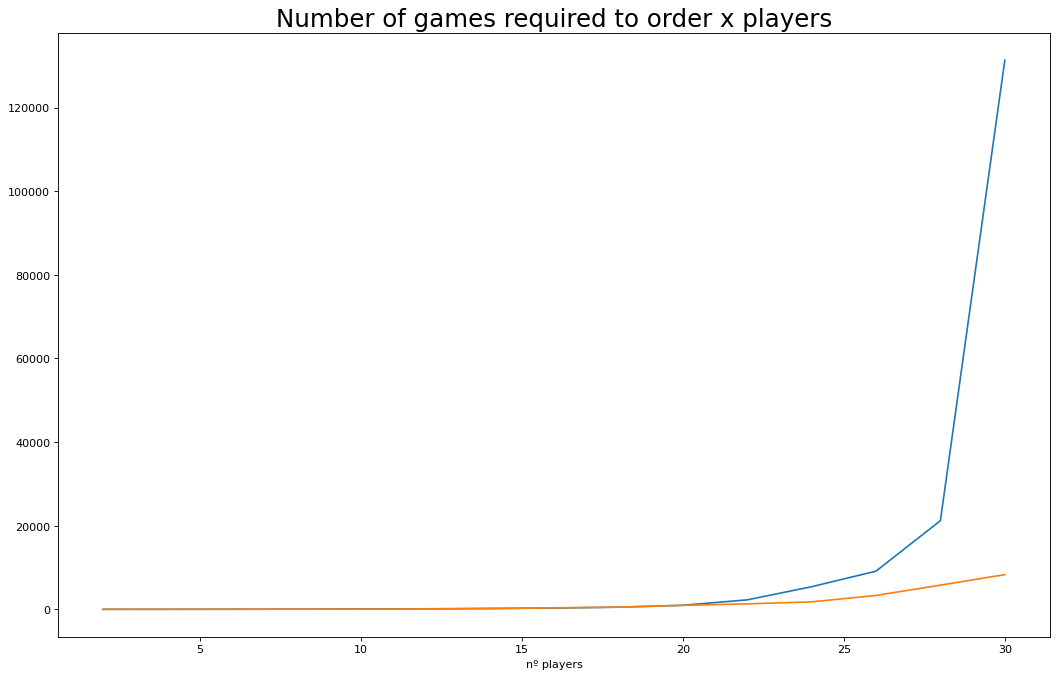

In [138]:
# Draw Stripplot

fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
#sns.stripplot(df_elo['nº players'], df_elo['games until ordered'], jitter=0.25, size=8, ax=ax, linewidth=.5)
df_rand2.groupby('nº players')['games until ordered'].mean().plot()
df_elo.groupby('nº players')['games until ordered'].mean().plot()   #.reset_index()['games until ordered']

# Decorations
plt.title('Number of games required to order x players', fontsize=22)
fig.savefig('Avg times to order elo img mean')
plt.show()

In [131]:
df_elo.groupby('nº players')['games until ordered'].mean()

nº players
2.0         1.370000
4.0         4.850000
6.0        15.450000
8.0        30.580000
10.0       64.700000
12.0      107.810000
14.0      213.040000
16.0      282.840000
18.0      508.800000
20.0      928.880000
22.0     1736.570000
24.0     3614.640000
26.0     6362.580000
28.0    12630.170000
30.0    69527.544554
Name: games until ordered, dtype: float64